In [1]:
#set up working dirs
model_folder = './model_checkpoints'
results_folder = './results/'

In [2]:
#imports
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_fscore_support, confusion_matrix, accuracy_score
from torchvision import transforms 
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim

In [3]:
#GET DATA
datafolder = '../../images/old_uk_not_uk/train'

transformations = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = ImageFolder(datafolder,transform=transformations) 

In [4]:
loss_weights = torch.Tensor([np.sum(np.array(dataset.targets) == 0), np.sum(np.array(dataset.targets) == 1)])#/len(dataset.targets)
loss_weights

tensor([978827.,  30701.])

In [4]:
#split training set into training and validation
from torch.utils.data.sampler import SubsetRandomSampler

#get the length of the dataset
dataset_size = len(dataset)

#get a list of indices
indices = list(range(dataset_size))

#shuffle the indices in place
np.random.shuffle(indices)

#pick training proportion
train_size, valid_size, test_size = int(0.7*dataset_size), int(0.2*dataset_size), int(0.1*dataset_size)

#separate indices
train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size+valid_size]
test_indices = indices[train_size+valid_size:]

#create samplers
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [5]:
#Dataloaders
train_loader = DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=128, sampler=valid_sampler)
test_loader = DataLoader(dataset, batch_size=128, sampler=test_sampler)

In [6]:
#device settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device in use: {device}')

Device in use: cuda:0


In [7]:
#Model

class myResNet50(nn.Module):
  def __init__(self, should_hook=False):
    super(myResNet50, self).__init__()

    self.should_hook = should_hook

    pretrainedmodel = resnet50(pretrained=True)
    
    #freezes weights
    if not self.should_hook:
      print("Freezing params...")
      for param in pretrainedmodel.parameters():
        param.requires_grad = False

    self.base = nn.Sequential(*list(pretrainedmodel.children())[:-2])

    self.avgpool = pretrainedmodel.avgpool

    #final layer
    infeatures = pretrainedmodel.fc.in_features
    self.fc = nn.Linear(infeatures, 2)

    # placeholder for the gradients
    self.gradients = None
    
  # method for the gradient extraction
  def get_activations_gradient(self):
    return self.gradients
  
  # method for the activation exctraction
  def get_activations(self, x):
    return self.base(x)

  # hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad


  def forward(self, x):
    #x.requires_grad = True
    x = self.base(x)
    
    # register the hook
    if self.should_hook:
      h = x.register_hook(self.activations_hook)
    
    # apply the remaining pooling
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    out = self.fc(x)
    return out


model = myResNet50(should_hook=False)
model.to(device)
#print(model)

model_name = 'uk_not_uk_classifier_shuffle_split'

Freezing params...


In [9]:
#model settings
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.fc.parameters(), lr=3e-4)


In [ ]:
#train network

# number of epochs to train the model
n_epochs = 60

valid_loss_min = np.Inf # track change in validation loss

#result files

train_results = results_folder+model_name+'_tr.csv'
val_results = results_folder+model_name+'_val.csv'

with open(train_results, 'a') as train_result:
    header = ",".join(['loss', 'accuracy', 'tn', 'fp', 'fn', 'tp', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1', 'count_0', 'count_1','auroc','\n'])
    train_result.write(header)

with open(val_results, 'a') as val_result:
    header = ",".join(['loss', 'accuracy', 'tn', 'fp', 'fn', 'tp', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1', 'count_0', 'count_1','auroc','saved','\n'])
    val_result.write(header)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # keep track of training and validation outputs
    tr_y_pred, tr_y_target = np.array([]), np.array([])
    val_y_pred, val_y_target = np.array([]), np.array([])

    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        #save data for metrics
        predictions = torch.exp(output)
      
        _, top_classes = predictions.topk(1,dim=1)

        tr_y_target = np.concatenate((tr_y_target,target.cpu()))
        tr_y_pred = np.concatenate((tr_y_pred,top_classes.squeeze(1).cpu()))
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        #save data for metrics
        predictions = torch.exp(output)
      
        _, top_classes = predictions.topk(1,dim=1)

        val_y_target = np.concatenate((val_y_target,target.cpu()))
        val_y_pred = np.concatenate((val_y_pred,top_classes.squeeze(1).cpu()))
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    # calulate metrics
    with open(train_results, 'a') as train_result:
      a, b = confusion_matrix(tr_y_target, tr_y_pred)
      tn, fp, fn, tp = *a, *b
      precision, recall, f1, support = precision_recall_fscore_support(tr_y_target, tr_y_pred)
      precision_0, precision_1, recall_0, recall_1, f1_0, f1_1, count_0, count_1 = *precision, *recall, *f1, *support
      accuracy = accuracy_score(tr_y_target, tr_y_pred)
      auroc = roc_auc_score(tr_y_target, tr_y_pred)
      line = ",".join([str(train_loss), str(accuracy), str(tn), str(fp), str(fn), str(tp), str(precision_0), str(precision_1), str(recall_0), str(recall_1), str(f1_0), str(f1_1), str(count_0), str(count_1), str(auroc), '\n'])
      train_result.write(line)

    with open(val_results, 'a') as val_result:
      a, b = confusion_matrix(val_y_target, val_y_pred)
      tn, fp, fn, tp = *a, *b
      precision, recall, f1, support = precision_recall_fscore_support(val_y_target, val_y_pred)
      precision_0, precision_1, recall_0, recall_1, f1_0, f1_1, count_0, count_1 = *precision, *recall, *f1, *support
      accuracy = accuracy_score(val_y_target, val_y_pred)
      auroc = roc_auc_score(val_y_target, val_y_pred)
      line = ",".join([str(valid_loss), str(accuracy), str(tn), str(fp), str(fn), str(tp), str(precision_0), str(precision_1), str(recall_0), str(recall_1), str(f1_0), str(f1_1), str(count_0), str(count_1), str(auroc), str(valid_loss <= valid_loss_min),'\n'])
      val_result.write(line)
      

        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving updated model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), model_folder+'/'+model_name+'.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.129672 	Validation Loss: 0.128250
Validation loss decreased (inf --> 0.128250).  Saving updated model ...
Epoch: 2 	Training Loss: 0.126043 	Validation Loss: 0.124481
Validation loss decreased (0.128250 --> 0.124481).  Saving updated model ...
Epoch: 3 	Training Loss: 0.124813 	Validation Loss: 0.125676


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 	Training Loss: 0.123974 	Validation Loss: 0.128706
Epoch: 5 	Training Loss: 0.123512 	Validation Loss: 0.122523
Validation loss decreased (0.124481 --> 0.122523).  Saving updated model ...


In [ ]:
#testing model
model.load_state_dict(torch.load(model_folder+'/'+model_name+'.pt'))

model.eval()
test_accuracy = 0.0

y_pred, y_target = np.array([]), np.array([])

test_results = results_folder+model_name+'_test.csv'

with torch.no_grad():
  for test_images, test_labels in test_loader:
      test_images, test_labels = test_images.to(device), test_labels.to(device)
      out = model(test_images)
      predictions = torch.exp(out)
      
      _, top_classes = predictions.topk(1,dim=1)

      y_target = np.concatenate((y_target,test_labels.cpu()))
      y_pred = np.concatenate((y_pred,top_classes.squeeze(1).cpu()))
      

with open(test_results, 'a') as test_result:
  header = ",".join(['accuracy', 'tn', 'fp', 'fn', 'tp', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1', 'count_0', 'count_1','auroc','\n'])
  a, b = confusion_matrix(y_target, y_pred)
  tn, fp, fn, tp = *a, *b
  precision, recall, f1, support = precision_recall_fscore_support(y_target, y_pred)
  precision_0, precision_1, recall_0, recall_1, f1_0, f1_1, count_0, count_1 = *precision, *recall, *f1, *support
  accuracy = accuracy_score(y_target, y_pred)
  auroc = roc_auc_score(y_target, y_pred)
  line = ",".join([str(accuracy), str(tn), str(fp), str(fn), str(tp), str(precision_0), str(precision_1), str(recall_0), str(recall_1), str(f1_0), str(f1_1), str(count_0), str(count_1), str(auroc), '\n'])
  test_result.write(header)
  test_result.write(line)
  print(f"Results in {test_results}")

print(f'Test Accuracy: {accuracy*100:.6f}%')

In [20]:
#GRAD CAM
imgs, labs = next(iter(test_loader))
imgs, labs = imgs.to(device), labs.to(device)

cam_model = myResNet50(should_hook=True)
cam_model.load_state_dict(torch.load(model_folder+'/'+model_name+'.pt'))

cam_model.to(device)
cam_model.eval()
img = imgs[0].unsqueeze(0)
res = cam_model.forward(img)
pred = res.argmax(dim=1)

res[:,pred.item()].backward()

res, pred

(tensor([[ 2.5654, -2.5990]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([0], device='cuda:0'))

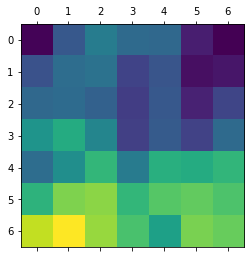

In [21]:
# pull the gradients out of the model
gradients = cam_model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = cam_model.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = heatmap.cpu()

heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

heatmap = heatmap.numpy()

In [33]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    return inp
    

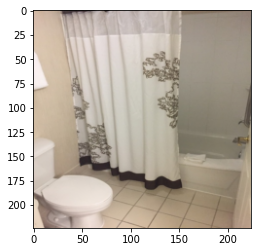

In [1]:
import cv2
img = imgs[0]
s1, s2 = img.size(1), img.size(2)
inp = imshow(img.cpu())
heatmap = cv2.resize(heatmap, (s1,s2))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + inp
#cv2.imwrite('/content/map.jpg', superimposed_img)
plt.imshow('image',superimposed_img)

NameError: name 'imgs' is not defined

In [27]:
!pip install opencv-python

     |████████████████████████████████| 49.5 MB 10.6 MB/s eta 0:00:01


In [ ]:
import cv2
img = imgs[0]
s1, s2 = img.size(1), img.size(2)
img = transforms.ToPILImage()(img)
#img = img.cpu().permute(1, 2, 0)
#img = img.numpy()
heatmap = cv2.resize(heatmap, (s1,s2))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/content/map.jpg', superimposed_img)

True

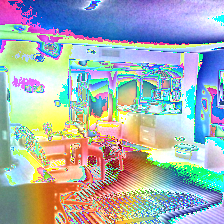

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


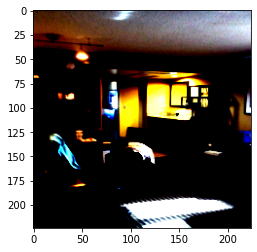

In [ ]:
original = imgs[0]
plt.imshow(original.cpu().permute(1, 2, 0))

In [ ]:
img1 = imgs[10]
s1, s2 = img1.size(1), img1.size(2)
img1 = transforms.ToPILImage()(img1)
plt.imshow(img1.permute(1,2,0))

AttributeError: ignored